# Tutorías CINV: III Spiketimes
En esta sección se muestra código implementado por miembros de CINV para el procesamiento de datos a partir de experimentos, particularmente obtener spikes a partir de sus archivos.

In [1]:
from configparser import ConfigParser, ExtendedInterpolation

import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import sys
import os
from tqdm import tqdm

from scipy.signal import hann, find_peaks, hilbert
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from chirp import *
from spikelib import visualizations as vis
from ipywidgets import IntSlider, interact, Dropdown, fixed
from spikelib import spiketools as spkt 

%matplotlib inline

config = ConfigParser(interpolation=ExtendedInterpolation())

In [2]:
# Chirp parameters
chirp_args = {}
chirp_args['chirp_duration'] = 35
chirp_args['base_amp'] = 0.5

chirp_args['t_adap'] = 2

chirp_args['amp_on'] = 1
chirp_args['t_on'] = 3
chirp_args['t_off'] = 3

chirp_args['freq_mod_final_freq'] = 15
chirp_args['freq_mod_time'] = 15
chirp_args['freq_mod_amp'] = 0.5
chirp_args['freq_mod_init_phase'] = 2 * np.pi

chirp_args['amp_mod_freq'] = 1
chirp_args['amp_mod_time'] = 8
chirp_args['amp_mod_max'] = 0.5

sample_rate = 1 / 60

chirp_signal = chirp_generator(sample_rate, chirp_args, splitted=True)
psth_bin = 0.06
fit_resolution = 0.001

['on_off', 'adap_0', 'freq', 'adap_1', 'amp', 'adap_2', 'freq_mod_max_lines', 'freq_mod_min_lines', 'freq_mod_zero_lines', 'amp_mod_max_lines', 'amp_mod_min_lines', 'full_signal', 'full_time']


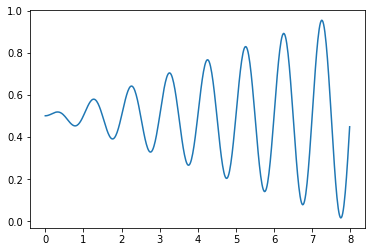

In [4]:
print(list(chirp_signal.keys()))
key = 'amp'
time, out = chirp_signal[key]
plt.plot(time, out)

In [5]:
exp_folder = 'MR-0387'

rootdir = os.getcwd()
os.chdir(exp_folder)
cfg_file = 'config.ini'
config.read(cfg_file)

config.set('PROJECT', 'path', '{}/'.format(os.getcwd()))
with open(cfg_file, 'w+') as configfile:
    config.write(configfile)
config.read(cfg_file)

os.chdir(rootdir)

In [6]:
exp_name = config['EXP']['name']
sorting_file = config['FILES']['sorting']
sync_file = config['SYNC']['events']

print('Experimento: {:s}'.format(exp_name))
print('Ruta a archivo sorting: {:s}'.format(sorting_file))
print('Ruta a archivo de eventos: {:s}'.format(sync_file))

Experimento: MR-0387
Ruta a archivo sorting: /home/preyesr/Documentos/retinal-bird-spikes/MEA-report/Tutorial CINV/MR-0387/sorting/MR-0387.result-1.hdf5
Ruta a archivo de eventos: /home/preyesr/Documentos/retinal-bird-spikes/MEA-report/Tutorial CINV/MR-0387/sync/event_list_MR-0387.csv


In [7]:
events = pd.read_csv(sync_file)
events.head()

mcd  n_frames  start_event  end_event  start_next_event  event_duration  \
0  0.0     18002        27135    6052603           6081075         6025468   
1  1.0     18002      6122817   12148286          12176423         6025469   
2  2.0      2100     12367013   13069906          13149902          702893   
3  2.0      2100     13149902   13852795          13932792          702893   
4  2.0      2100     13932792   14635684          14715681          702892   

   inter_event_duration  start_event_sec  end_event_sec  start_next_event_sec  \
0                 28472          1.35675      302.63015             304.05375   
1                 28137        306.14085      607.41430             608.82115   
2                 79996        618.35065      653.49530             657.49510   
3                 79997        657.49510      692.63975             696.63960   
4                 79997        696.63960      731.78420             735.78405   

   event_duration_sec  inter_event_duration_sec protocol_name   nd  intensity  \
0           301.27340                   1.42360      scotopic  nd3        0.0   
1           301.27345                   1.40685      photopic  nd3      255.0   
2            35.14465                   3.99980         chirp  nd3      255.0   
3            35.14465                   3.99985         chirp  nd3      255.0   
4            35.14460                   3.99985         chirp  nd3      255.0   

  extra_description repetition_name  \
0           initial         rep_000   
1           initial         rep_000   
2               NaN         rep_000   
3               NaN         rep_001   
4               NaN         rep_002   

                                     repeated_frames  #repeated_frames  
0  [  27135   27805   28474 ... 6050595 6051265 6...              9001  
1  [ 6122817  6123487  6124156 ... 12146278 12146...              9001  
2                                                 []                 0  
3                                                 []                 0  
4                                                 []                 0

In [8]:
fields_df = ['start_event', 'end_event']
mask_chirp = events['protocol_name'] == 'chirp'

chirp_events = events[mask_chirp]
times_chirp = chirp_events[fields_df] #times_chirp = events[mask_chirp][fields_df]
times_chirp

start_event  end_event
2      12367013   13069906
3      13149902   13852795
4      13932792   14635684
5      14715681   15418574
6      15498570   16202133
7      16282129   16985357
8      17065353   17768246
9      17848242   18551135
10     18631132   19334024
11     19414021   20116914
12     20196910   20899803
13     20979800   21682692
14     21762689   22465582
15     22545578   23248471
16     23328468   24031360
17     24111357   24814250
18     24894246   25597139
19     25677136   26380028
20     26460025   27162918
21     27242914   27946476
22     28026473   28729366

In [9]:
chirp_dur = np.mean(np.diff(np.array(times_chirp), axis=1) / 20000.0)
chirp_dur

35.148623809523805

In [10]:
with h5py.File(sorting_file, 'r') as spks:
    print(spks)

<HDF5 file "MR-0387.result-1.hdf5" (mode r)>


In [19]:
key = 'temp_0'
with h5py.File(sorting_file, 'r') as spks:
    spikes = spks['spiketimes/{:s}'.format(key)][...]
    print(spikes)

[[4.96630000e+04]
 [1.64405000e+05]
 [2.08275000e+05]
 ...
 [1.33511643e+08]
 [1.33588302e+08]
 [1.33604718e+08]]


In [17]:
with h5py.File(sorting_file, 'r') as spks:
    spikes = spks['spiketimes/{:s}'.format(key)][...] / 20000.0
    
    start_event = np.array(times_chirp['start_event']) / 20000.0
    end_event = np.array(times_chirp['end_event']) / 20000.0
    trials_chirp = spkt.get_trials(spikes, start_event, end_event)

    #print(trials_chirp)

spikes_chirp = spkt.flatten_trials(trials_chirp)

<BarContainer object of 584 artists>

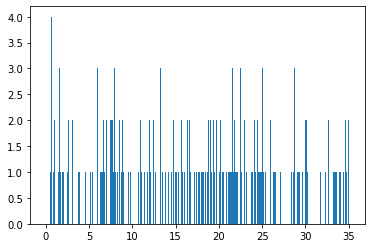

In [18]:
psth_bin = 0.06  # In sec
exp_bins = np.linspace(0, chirp_dur, int(chirp_dur / psth_bin))
psth, _ = np.histogram(spikes_chirp, bins=exp_bins)

plt.bar(exp_bins[:-1], psth, width=psth_bin)

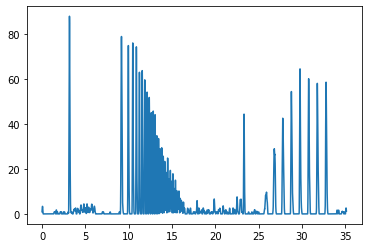

In [15]:
fit_resolution = 0.001  # In sec
exp_time = np.linspace(0, chirp_dur, int(chirp_dur / fit_resolution))
exp_resp = spkt.est_pdf(trials_chirp, exp_time, bandwidth=psth_bin, norm_factor=psth.max())

plt.plot(exp_time, exp_resp)

In [20]:
start_end_path = config['SYNC']['frametime']
repeated_path = config['SYNC']['repeated']
output_file = os.path.join(config['SYNC']['folder'],
                           'sub_events_chirp_{}.csv'.format(exp_name))

names = ['ON', 'OFF', 'adap_0', 'FREQ', 'adap_1', 'AMP', 'adap_2']
times = [3, 3, 2, 15, 2, 8, 2]

subevents = get_chirp_subevents(sync_file, start_end_path, repeated_path, output_file, names, times)

In [21]:
key = 'temp_5'
with h5py.File(sorting_file, 'r') as spks:
    # Archivo chirp.py
    output, char = get_chirp_response(spks['spiketimes'], subevents, chirp_args, key, psth_bin, fit_resolution)
    print(output.keys(), '\n')
    print(char.keys())

dict_keys(['flash_time', 'flash_resp', 'freq_time', 'freq_response', 'freq_peaks', 'freq_on_peaks', 'freq_on_delays', 'freq_on_fresp', 'freq_on_fitting', 'freq_on_delay_fit', 'freq_off_peaks', 'freq_off_delays', 'freq_off_fresp', 'freq_off_fitting', 'freq_off_delay_fit', 'amp_time', 'amp_response', 'amp_peaks', 'amp_on_peaks', 'amp_on_delays', 'amp_on_fresp', 'amp_on_fitting', 'amp_off_peaks', 'amp_off_delays', 'amp_off_fresp', 'amp_off_fitting']) 

dict_keys(['flash_type', 'SNR', 'QI', 'flash_char', 'amp_char', 'freq_char'])


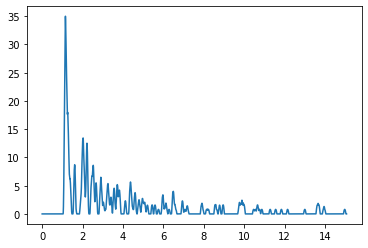

In [24]:
plt.plot(output['freq_time'], output['freq_response'])

In [25]:
char

{'flash_type': 3,
 'SNR': 11.417579049538794,
 'QI': 0.4488786566699504,
 'flash_char': array([ 1.60000063e-01,  1.60601254e-01, -3.08673321e-01,  5.10000202e-02,
         2.02000080e-01,  9.24081626e-01,  9.35025263e-01,  5.88365074e-01,
         3.81649555e-01,  3.11676515e+01,  5.90000000e+01]),
 'amp_char': array([        nan,         nan,         nan,         nan,  1.11860007,
         0.3123897 , 16.28889291, 11.7944395 ,  9.98760154,  2.37146839,
         1.01143385,  0.60087618]),
 'freq_char': array([1.13426545e+01, 2.95409448e-10, 2.69669027e+00, 2.08004325e+00,
        4.79300000e+00, 1.72483178e-01, 3.50000000e+01, 5.32688732e-01,
        1.26388920e+00, 2.87158709e+00, 3.71500000e+00, 3.72836955e-01,
        1.00000000e+00])}